# Çok Sınıflı Sınıflandırma

Veriler ikiden fazla sınıfa ayrılabiliyorsa, çok sınıflı bir sınıflandırma algoritması kullanmanız gerekir.

Çok sınıflı sınıflandırma, birden çok ikili sınıflandırıcının bir kombinasyonu olarak düşünülebilir. Soruna yaklaşmanın iki yolu vardır:

- **Bire Karşı Kalan (OVR)**, olası her sınıf değeri için bir sınıflandırıcının oluşturulduğu, tahminin *bu* sınıf olduğu durumlar için pozitif sonuç ve tahminin başka herhangi bir sınıf olduğu durumlar için negatif tahminler sınıf. Dört olası şekil sınıfına (*kare*, *daire*, *üçgen*, *altıgen*) sahip bir sınıflandırma problemi, aşağıdakileri tahmin eden dört sınıflandırıcı gerektirir:
    - *kare* ya da değil
    - *daire* ya da değil
    - *üçgen* veya değil
    - *altıgen* veya değil
    
- **Bire Karşı Bir (OVO)**, olası her sınıf çifti için bir sınıflandırıcı oluşturulur. Dört şekil sınıflı sınıflandırma problemi, aşağıdaki ikili sınıflandırıcıları gerektirir:
    - *kare* veya *daire*
    - *kare* veya *üçgen*
    - *kare* veya *altıgen*
    - *daire* veya *üçgen*
    - *daire* veya *altıgen*
    - *üçgen* veya *altıgen*

Her iki yaklaşımda da, sınıflandırıcıları birleştiren genel model, hangi sınıfın tahmin edileceğini belirlemek için bireysel ikili sınıflandırıcılardan üretilen olasılıkların kullanıldığı bir tahmin vektörü üretir.

Neyse ki, scikit-learn dahil olmak üzere çoğu makine öğrenimi çerçevesinde, çok sınıflı bir sınıflandırma modeli uygulamak, ikili sınıflandırmadan önemli ölçüde daha karmaşık değildir - ve çoğu durumda, ikili sınıflandırma için kullanılan tahmin ediciler, bir OVR algoritmasını, bir OVO'yu soyutlayarak çok sınıflı sınıflandırmayı dolaylı olarak destekler, algoritma veya herhangi birinin seçimine izin vererek.

### Verileri keşfetme

Birden çok sınıfın gözlemlerini içeren bir veri kümesini inceleyerek başlayalım. Üç farklı penguen türünün gözlemlerini içeren bir veri seti kullanacağız.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("penguins.csv")

In [4]:
# 10 gözlemden oluşan rastgele bir örnek 
sample = df.sample(10)
sample

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
224,48.2,15.6,221.0,5100.0,1
92,34.0,17.1,185.0,3400.0,0
78,36.2,16.1,187.0,3550.0,0
236,44.9,13.8,212.0,4750.0,1
332,45.2,16.6,191.0,3250.0,2
77,37.2,19.4,184.0,3900.0,0
105,39.7,18.9,184.0,3550.0,0
324,51.5,18.7,187.0,3250.0,2
290,45.9,17.1,190.0,3575.0,2
292,50.3,20.0,197.0,3300.0,2


Veri kümesi aşağıdaki sütunları içerir:
* **CulmenLength**: Penguenin gagasının mm cinsinden uzunluğu.
* **CulmenDepth**: Penguenin gagasının mm cinsinden derinliği.
* **FlipperLength**: Penguenin yüzgecinin mm cinsinden uzunluğu.
* **BodyMass**: Penguenin gram cinsinden vücut kütlesi.
* **Species**: Penguenin türünü temsil eden bir tamsayı değeri.

**Species** sütunu, bir modeli tahmin etmesi için eğitmek istediğimiz etikettir. Veri seti, 0, 1 ve 2 olarak kodlanan üç olası türü içerir. Gerçek tür adları aşağıdaki kodla gösterilir:

In [8]:
penguin_classes = ["Adelie", "Gentoo", "Chinstrap"]
print(sample.columns[0:5].values, "SpeciesName")
# Burada, 'sample' adlı bir veri çerçevesindeki ilk 5 sütunun adlarını ve yanına 'SpeciesName' yazısını ekrana basıyor. 

for index, row in df.sample(10).iterrows():
    # 'df' bir veri çerçevesinden 10 örnek seçiyor ve her bir satır için döngü başlatıyor. 
    # Bu döngü, seçilen 10 örnek üzerinde çalışacak.
    print("[", row[0], row[1], row[3], int(row[4]), "]", penguin_classes[int(row[4])])
    # Her bir satırın özelliklerini (kolonları) ekrana yazdırıyor. 
    # row üzerinde indexleme yapılarak sırasıyla 0, 1, 2, 3 ve 4. kolonlar alınıyor ve ekrana yazdırılıyor. 
    # Ayrıca, 4. kolon sayısal bir değer olmalıdır, bu nedenle int(row[4]) ile tam sayıya dönüştürülüyor. 
    # Son olarak, bu sayı penguin_classes listesinin indeksine göre uygun penguen türünün adını ekrana yazdırıyor.

['CulmenLength' 'CulmenDepth' 'FlipperLength' 'BodyMass' 'Species'] SpeciesName
[ 41.0 20.0 4725.0 0 ] Adelie
[ 41.6 18.0 3950.0 0 ] Adelie
[ 51.5 16.3 5500.0 1 ] Gentoo
[ 45.4 18.7 3525.0 2 ] Chinstrap
[ 39.5 16.7 3250.0 0 ] Adelie
[ 39.6 17.7 3500.0 0 ] Adelie
[ 51.4 19.0 3950.0 2 ] Chinstrap
[ 53.5 19.9 4500.0 2 ] Chinstrap
[ 41.7 14.7 4700.0 1 ] Gentoo
[ 50.5 15.9 5550.0 1 ] Gentoo


Artık verilerdeki özelliklerin ve etiketlerin neyi temsil ettiğini bildiğimize göre, veri kümesini inceleyelim. Öncelikle, herhangi bir eksik (*null*) değer olup olmadığına bakalım.

In [9]:
df.isnull().sum()

CulmenLength     2
CulmenDepth      2
FlipperLength    2
BodyMass         2
Species          0
dtype: int64

Bazı eksik özellik değerleri var, ancak eksik etiket yok gibi görünüyor. Biraz daha derine inelim ve null içeren satırları görelim.

In [12]:
df[df.isnull().any(axis=1)]

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
3,NaN,NaN,NaN,NaN,0
271,NaN,NaN,NaN,NaN,1


Hiçbir özellik değeri içermeyen iki satır vardır (*NaN*, "sayı değil" anlamına gelir), dolayısıyla bunlar bir modelin eğitiminde yararlı olmayacaktır. Onları veri kümesinden atalım.

In [13]:
df = df.dropna()
df.isnull().sum()

CulmenLength     0
CulmenDepth      0
FlipperLength    0
BodyMass         0
Species          0
dtype: int64

Artık eksik değerleri ele aldığımıza göre, bazı kutu grafikler oluşturarak özelliklerin etiketle nasıl ilişkili olduğunu inceleyelim.

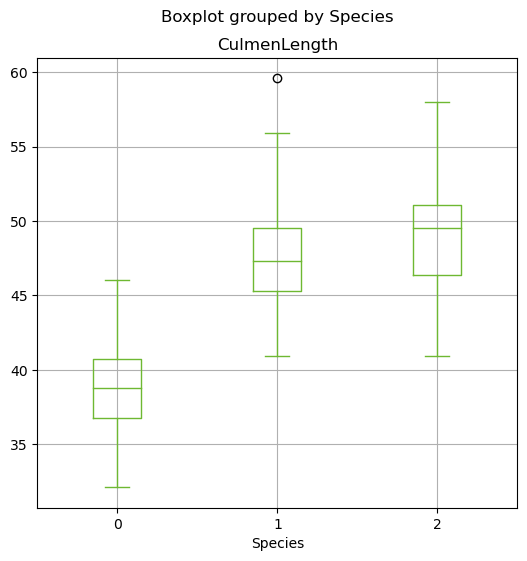

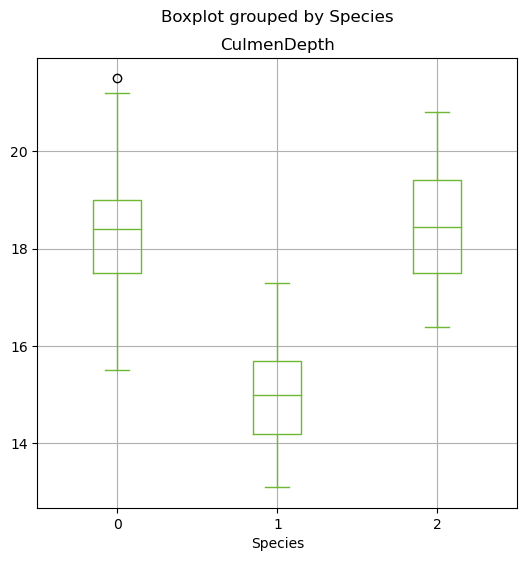

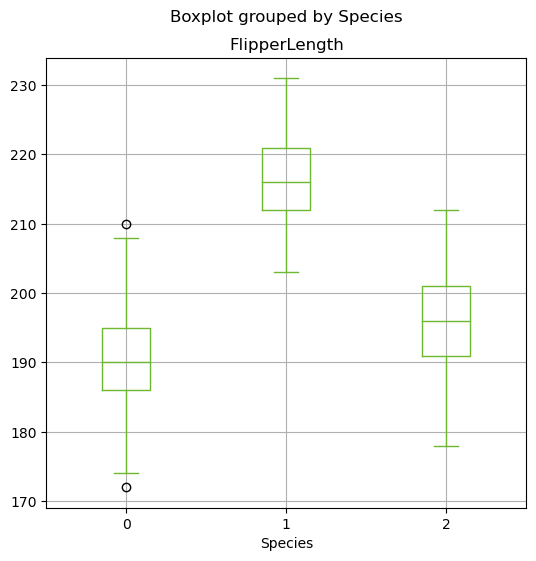

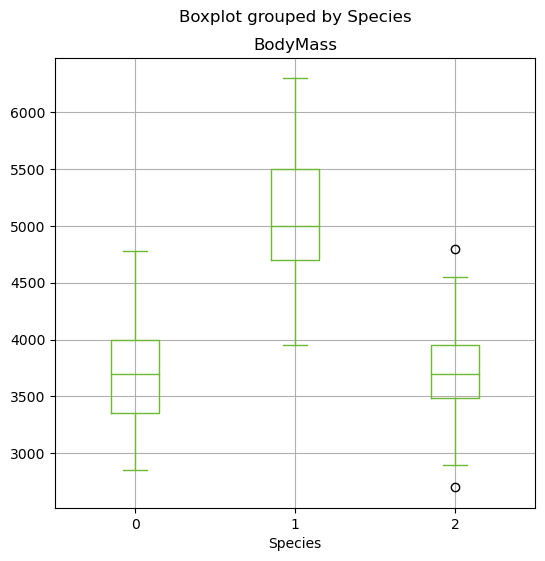

In [14]:
df_features = ["CulmenLength", "CulmenDepth", "FlipperLength", "BodyMass"]
df_label = "Species"

for col in df_features:
    df.boxplot(column=col, by=df_label, figsize=(6,6), color="#6eb832")
plt.show()    

Kutu çizimlerinden, tür 0 ve 2'nin (Adelie ve Chinstrap) culmen derinliği, yüzgeç uzunluğu ve vücut kütlesi için benzer veri profillerine sahip olduğu görülüyor, ancak Chinstrap'ların daha uzun culmenleri var. Tür 1 (Gentoo), diğerlerinden oldukça net bir şekilde farklı özelliklere sahip olma eğilimindedir; bu da iyi bir sınıflandırma modeli geliştirmemize yardımcı olacaktır.

### Verileri hazırlama

Tıpkı ikili sınıflandırmada olduğu gibi, modeli eğitmeden önce, özellikleri ve etiketi ayırmamız ve ardından verileri eğitim ve doğrulama için alt kümelere ayırmamız gerekir. Eğitim ve doğrulama veri kümelerindeki her bir etiket değerinin oranını korumak için verileri bölerken ayrıca bir *katmanlaştırma* tekniği uygulayacağız.

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X, y = df[df_features].values, df[df_label].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0, stratify=y)
# train_test_split işlevinde stratify=y kullanımı, penguins veri çerçevesindeki hedef değişkeni y (etiketler) 
# dikkate alarak veriyi bölerken sınıf dengesini korumak için kullanılıyor.

### Çok sınıflı bir sınıflandırıcıyı eğitme ve değerlendirme

Artık bir dizi eğitim özelliğimiz ve karşılık gelen eğitim etiketlerimiz olduğuna göre, bir model oluşturmak için verilere çok sınıflı bir sınıflandırma algoritması sığdırabiliriz. Çoğu scikit-learn sınıflandırma algoritması doğası gereği çok sınıflı sınıflandırmayı destekler. Bir lojistik regresyon algoritması deneyeceğiz.

In [18]:
from sklearn.linear_model import LogisticRegression

In [20]:
# Düzenleme oranını ayarlayın
reg = 0.1

model = LogisticRegression(C=1/reg, solver="lbfgs", multi_class="auto", max_iter=10000)
# C=1/reg: Bu, düzenleme katsayısını belirleyen parametredir. 
# solver='lbfgs': Lojistik regresyonun optimize edilmesi için kullanılacak algoritma. '
# lbfgs', sınıf içindeki 'multi_class' parametresi 'auto' olduğunda önerilen bir seçenektir.
# multi_class='auto': Bu, çoklu sınıf (multiclass) problemler için lojistik regresyon modelini kullanacağımızı belirtir. 
# Model, birden fazla sınıfı etiketleyebilir.
# max_iter=10000: Algoritmanın maksimum iterasyon sayısı. 

model.fit(X_train, y_train)

LogisticRegression(C=10.0, max_iter=10000)

Artık test özelliklerinin etiketlerini tahmin etmek için eğitilmiş modeli kullanabilir ve tahmin edilen etiketleri gerçek etiketlerle karşılaştırabiliriz:

In [21]:
predictions = model.predict(X_test)
print("Predicted labels: ", predictions[:15])
print("Actual labels: ", y_test[:15])

Predicted labels:  [0 1 0 2 2 1 1 1 0 2 2 1 2 1 2]
Actual labels:  [0 1 2 2 2 1 1 1 0 2 2 1 2 1 2]


Bir sınıflandırma raporuna bakalım.

In [23]:
from sklearn.metrics import classification_report

In [24]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97        45
           1       1.00      1.00      1.00        37
           2       0.95      0.90      0.93        21

    accuracy                           0.97       103
   macro avg       0.97      0.96      0.96       103
weighted avg       0.97      0.97      0.97       103



İkili sınıflandırmada olduğu gibi, rapor her sınıf için *kesinlik* ve *hatırlama* ölçümlerini içerir. Ancak, ikili sınıflandırma ile *pozitif* sınıfın puanlarına odaklanabilirken; bu durumda, birden fazla sınıf vardır, bu nedenle modelin üç sınıfta da ne kadar iyi performans gösterdiğini anlamak için genel bir metriğe (makro veya ağırlıklı ortalama) bakmamız gerekir.

Scikit-learn metrik puan sınıflarını kullanarak genel metrikleri rapordan ayrı olarak alabilirsiniz, ancak çok sınıflı sonuçlarda kesinlik ve geri çağırma için hangi ortalama metriği kullanmak istediğinizi belirtmeniz gerekir.

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [26]:
print("Overall Accuracy: ", accuracy_score(y_test, predictions))
print("Overall Precision: ", precision_score(y_test, predictions, average="macro"))
print("Overall Recall: ", recall_score(y_test, predictions, average="macro"))

Overall Accuracy:  0.970873786407767
Overall Precision:  0.9688405797101449
Overall Recall:  0.9608465608465608


Şimdi modelimizin karışıklık matrisine bakalım:

In [27]:
from sklearn.metrics import confusion_matrix

In [30]:
cm = confusion_matrix(y_test, predictions)
print(cm)

[[44  0  1]
 [ 0 37  0]
 [ 2  0 19]]


Karışıklık matrisi, her sınıf için tahmin edilen ve gerçek etiket değerlerinin kesişimini gösterir - basit bir ifadeyle, sol üstten sağ alta çapraz kesişmeler, doğru tahminlerin sayısını gösterir.

Birden çok sınıfla uğraşırken, bunu aşağıdaki gibi bir ısı haritası olarak görselleştirmek genellikle daha sezgiseldir:

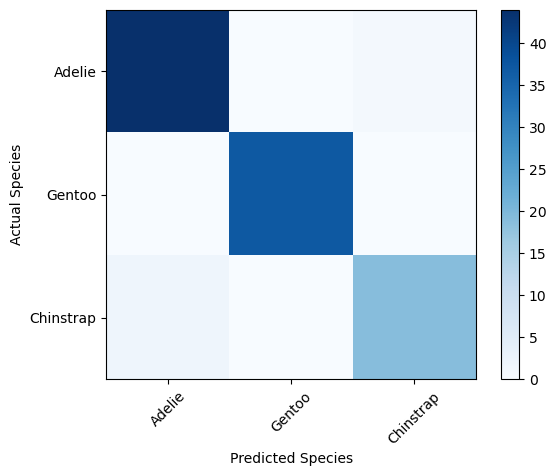

In [38]:
plt.imshow(cm, interpolation="nearest", cmap="Blues")
plt.colorbar()
tick_marks = np.arange(len(penguin_classes))
plt.xticks(tick_marks, penguin_classes, rotation=45)
plt.yticks(tick_marks, penguin_classes)
plt.xlabel("Predicted Species")
plt.ylabel("Actual Species")
plt.show()

Karışıklık matrisi grafiğindeki daha koyu kareler, çok sayıda vakayı gösterir ve umarım, tahmin edilen ve gerçek etiketin aynı olduğu durumları gösteren daha koyu karelerden oluşan çapraz bir çizgi görebilirsiniz.

Çok sınıflı bir sınıflandırma modeli söz konusu olduğunda, gerçek pozitif oranı ile yanlış pozitif oranı gösteren tek bir ROC eğrisi mümkün değildir. Ancak, her sınıf için bir ROC tablosu oluşturmak üzere Bire Karşı Kalan (OVR) karşılaştırmasında her sınıfın oranlarını kullanabilirsiniz.

In [39]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

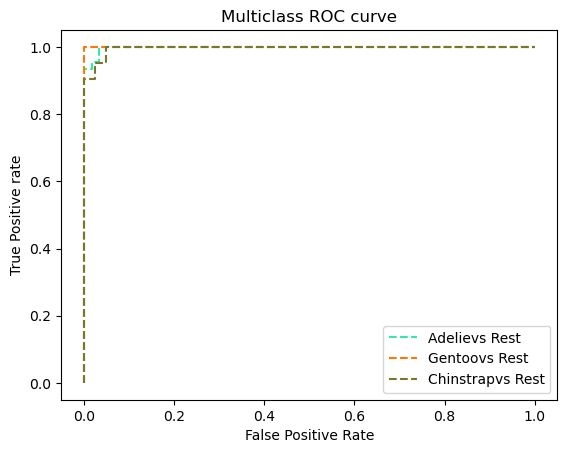

In [42]:
# Sınıf olasılık puanlarını alın
penguin_prob = model.predict_proba(X_test)

# Sınıf olasılık puanlarını alın
fpr = {}
tpr = {}
thresh = {}
for i in range(len(penguin_classes)):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, penguin_prob[:,i], pos_label=i)
    
# ROC grafiğini çizin
plt.plot(fpr[0], tpr[0], linestyle="--", color="#35e7ad", label=penguin_classes[0] + "vs Rest")
plt.plot(fpr[1], tpr[1], linestyle="--", color="#fd7807", label=penguin_classes[1] + "vs Rest")
plt.plot(fpr[2], tpr[2], linestyle="--", color="#797729", label=penguin_classes[2] + "vs Rest")
plt.title("Multiclass ROC curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc="best")

ROC performansını ölçmek için, tüm OVR eğrilerinin ortalaması alınan eğri puanı altındaki toplam alanı hesaplayabilirsiniz.

In [44]:
auc = roc_auc_score(y_test, penguin_prob, multi_class="ovr")
print("Average AUC", auc)

Average AUC 0.9981999902100828


### Bir ardışık düzende verileri ön işleme
Yine, tıpkı ikili sınıflandırmada olduğu gibi, bir modeli eğitmek için verileri bir algoritmaya uydurmadan önce verilere ön işleme adımlarını uygulamak için bir ardışık düzen kullanabilirsiniz. Eğitimden önce sayısal özellikleri dönüşüm adımlarında ölçeklendirerek penguen tahmincisini geliştirip geliştiremeyeceğimize bakalım. Ayrıca yapabileceğimizi göstermek için farklı bir algoritma (bir destek vektör makinesi) deneyeceğiz!

In [45]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [51]:
# Sayısal sütunlar için ön işlemeyi tanımlayın (ölçeklendirin)
feature_columns = [0,1,2,3]
feature_transformer = Pipeline(steps=[("scaler", StandardScaler())])

# Ön işleme adımları oluşturun
preprocessor = ColumnTransformer(transformers=[("preprocess", feature_transformer, feature_columns)])

# Eğitim pipeline oluşturun
pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                           ("regressor", SVC(probability=True))])

# eğitim setinde doğrusal bir regresyon modeli eğitin
model = pipeline.fit(X_train, y_train)
print(model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('preprocess',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3])])),
                ('regressor', SVC(probability=True))])


Artık yeni modeli değerlendirebiliriz.

Overall Accuracy:  0.9805825242718447
Overall Precision:  0.9767195767195768
Overall Recall:  0.9767195767195768
Average AUC:  0.9990361381446328


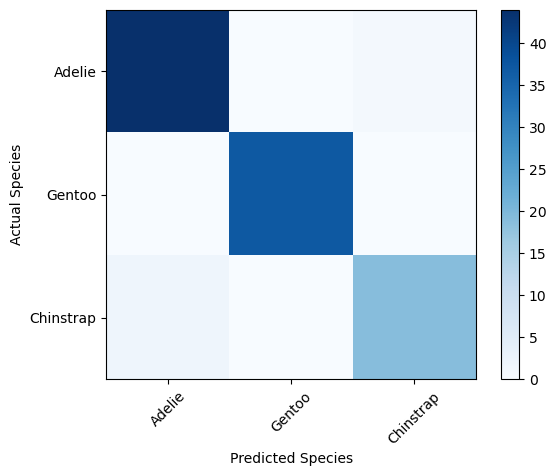

In [53]:
# Test verilerinden tahminler alın
predictions = model.predict(X_test)
prob = model.predict_proba(X_test)

# Genel metrikler
print("Overall Accuracy: ", accuracy_score(y_test, predictions))
print("Overall Precision: ", precision_score(y_test, predictions, average="macro"))
print("Overall Recall: ", recall_score(y_test, predictions, average="macro"))
print("Average AUC: ", roc_auc_score(y_test, prob, multi_class="ovr"))

# Karışıklık matrisi
plt.imshow(cm, interpolation="nearest", cmap="Blues")
plt.colorbar()
tick_marks = np.arange(len(penguin_classes))
plt.xticks(tick_marks, penguin_classes, rotation=45)
plt.yticks(tick_marks, penguin_classes)
plt.xlabel("Predicted Species")
plt.ylabel("Actual Species")
plt.show()

### Modeli yeni veri gözlemleriyle kullanın

In [58]:
x_new = np.array([[49.5,18.4,195, 3600],
                  [38.2,20.1,190,3900]])
print("New samples:\n{}".format(x_new))

New samples:
[[  49.5   18.4  195.  3600. ]
 [  38.2   20.1  190.  3900. ]]


In [60]:
predictions = model.predict(x_new)

In [61]:
for prediction in predictions:
    print(prediction, "(" + penguin_classes[prediction] + ")")

2 (Chinstrap)
0 (Adelie)
